 need 3 models generated using existing data (features and labels):
- Logistic Regression
- Random Forest
- XGB or Neural network

Requirements:
1) Perform data analysis (drop missing features, drop incorrect labels, drop highly correlated features, etc)

2) Generate training Python scripts using sklearn for each model that accepts input data, sanitizes data and outputs model + ROC curve + features importance.

3) Make script generic enough to work with any feature names and count (defined in external text file).

4) Generate Prediction Python script (sklearn) that accepts never seen data (no labels, just features) and uses models above to generate prediction score.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sampling methods for imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# models for training and testing the dataset
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# spliting the data into train and test dataset
from sklearn.model_selection import train_test_split

# time model for calculating the time requied for the step
import time

# for checking the performance of the model
from sklearn.metrics import roc_curve,roc_auc_score,classification_report,confusion_matrix
import sklearn.metrics as metrics
import scikitplot as skplt

# ignoring the unwanted warnings
import warnings

warnings.filterwarnings('ignore')

** **
**load the datasets**

In [4]:
features = pd.read_csv('features.csv')
labels = pd.read_csv('labels.csv')

** **
**basic steps**
    
    remove the duplicates
    removes nan values
    make dataset with same key from features and label
    
**output of the function**
    
    unseen dataset from the given dataset
    preprocesed dataset

In [5]:
def basic_steps(features_dataset,labels_dataset):
    labels.sort_values(by = ['key'], ignore_index=True, inplace=True)
    features.sort_values(by = ['key'],ignore_index=True,inplace=True)
    
# droping the duplicates and getting key
    f_key = features.drop_duplicates().key
    l_key = labels.key

# sorting variables
    f_key = sorted(f_key)
    l_key = sorted(l_key)
    
# droping the duplicates and the nan values
    features.dropna(inplace=True)
    features.drop_duplicates(inplace=True,ignore_index=True)
    
# getting dataset with the keys in labels and removing the extra keys
    features_labels = features[features.key.isin(l_key)]
    features_labels = pd.concat([features,labels.label],axis='columns')
    

# since the data is imbalanced in the for keys and label and 
# after concating the both of the data we need to remove the NaN values from the label 
    features_labels_not_nan = features_labels.dropna()
    features_labels_unseen = features_labels[features_labels.label.isna() == True]
    
# getting two values because we have the Nan in label which will act as unseen data
    return features_labels_unseen,features_labels_not_nan,features_labels


In [6]:
unseen_data,features_labels,raw_features = basic_steps(features,labels)

In [7]:
print(features_labels.shape)
features_labels.label.value_counts()

(651441, 78)


1.0    589222
0.0     62219
Name: label, dtype: int64

In [8]:
features_labels.head(10)

,key,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature68,feature69,feature70,feature71,feature72,feature73,feature74,feature75,feature76,label
0,000000d77fdee024f61e5941861e02838d2214800ec8e9...,1,1,0,1,0,1,1,1,1,...,1,1,1,0,0,0,1,1,0,1.0
1,0000137f327e090be14f03c3eb25520bc011d21ad3fdd9...,1,1,0,1,0,0,1,1,1,...,0,1,1,0,0,1,1,1,0,1.0
2,00001c11084d7df1854a14a30340b774ab3e5b1fab31fe...,0,1,1,1,0,0,1,0,1,...,1,1,0,1,0,1,0,0,0,1.0
3,00001dbb91730b3ee0759202dec4905ad4152dcf303f3f...,0,1,0,1,0,1,1,1,1,...,0,1,1,0,0,0,0,1,0,1.0
4,00003084e2dac1a9b681bf1a744bc080b2a619e52471ee...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
5,00004d0edbe109811a27af46547d96ea87532ab43ebaa6...,0,1,0,1,0,1,0,1,0,...,1,1,0,0,0,0,0,1,0,0.0
6,00005c15a38a931f09916ae861c8f179d1ea798459f648...,1,1,0,1,0,1,1,1,1,...,0,1,0,0,0,1,1,1,0,1.0
7,000067e9f9f63bb540b3abe2c2915714cb1a7a881d92f6...,0,1,1,0,0,1,0,1,1,...,1,1,0,0,1,0,0,0,0,1.0
8,00006e4b1ac23a70fb8edf67ed43b47237f7d983b891ef...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
9,00008b41f266be76be0ffd6a93bab16a9a685e47e5ca7d...,0,1,1,1,0,1,1,0,1,...,1,1,1,1,0,1,1,1,0,1.0


In [9]:
features.head(10)

,key,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature67,feature68,feature69,feature70,feature71,feature72,feature73,feature74,feature75,feature76
0,000000d77fdee024f61e5941861e02838d2214800ec8e9...,1,1,0,1,0,1,1,1,1,...,1,1,1,1,0,0,0,1,1,0
1,0000137f327e090be14f03c3eb25520bc011d21ad3fdd9...,1,1,0,1,0,0,1,1,1,...,0,0,1,1,0,0,1,1,1,0
2,00001c11084d7df1854a14a30340b774ab3e5b1fab31fe...,0,1,1,1,0,0,1,0,1,...,1,1,1,0,1,0,1,0,0,0
3,00001dbb91730b3ee0759202dec4905ad4152dcf303f3f...,0,1,0,1,0,1,1,1,1,...,0,0,1,1,0,0,0,0,1,0
4,00003084e2dac1a9b681bf1a744bc080b2a619e52471ee...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,00004d0edbe109811a27af46547d96ea87532ab43ebaa6...,0,1,0,1,0,1,0,1,0,...,1,1,1,0,0,0,0,0,1,0
6,00005c15a38a931f09916ae861c8f179d1ea798459f648...,1,1,0,1,0,1,1,1,1,...,0,0,1,0,0,0,1,1,1,0
7,000067e9f9f63bb540b3abe2c2915714cb1a7a881d92f6...,0,1,1,0,0,1,0,1,1,...,1,1,1,0,0,1,0,0,0,0
8,00006e4b1ac23a70fb8edf67ed43b47237f7d983b891ef...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,00008b41f266be76be0ffd6a93bab16a9a685e47e5ca7d...,0,1,1,1,0,1,1,0,1,...,1,1,1,1,1,0,1,1,1,0


In [10]:
labels.label.head(10)

0    1
1    1
2    1
3    1
4    1
5    0
6    1
7    1
8    1
9    1
Name: label, dtype: int64

In [11]:
print(unseen_data.shape)
unseen_data.head()

(348012, 78)


,key,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature68,feature69,feature70,feature71,feature72,feature73,feature74,feature75,feature76,label
651441,a6de195bf6901ed5216b83f8c411c959feabcdf586242a...,1,1,0,1,0,1,1,1,1,...,1,1,1,0,0,1,1,1,0,NaN
651442,a6de1c83c47983f8d9c6f02a6ed6677f025e9524cd5839...,1,1,1,1,1,1,0,1,1,...,1,1,0,0,0,1,1,1,0,NaN
651443,a6de25bcd224e01320886eff93fc9779a353dc3d917021...,1,1,0,1,0,1,1,1,1,...,0,1,1,0,0,1,1,1,0,NaN
651444,a6de7c26d881f5b8e39169dcee843abb5c5cfd710a8f44...,0,1,1,1,0,1,1,0,1,...,1,1,1,1,1,1,1,1,0,NaN
651445,a6de987449619b0318ff2b3cff78765b84b0c90c36d8f1...,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,0,1,0,NaN


**visualization and important features**

correlation of the of the features and then remove the highly correlated data

**output of this function**
    
    important features names
    important features dataset

In [20]:
def visual_and_imp_features(dataset):
    corelation = str(input('are you doing this for first time on the dataset (yes,no) : '))
    
# this is because we will use this further and also on the other datasets too    
    if corelation == 'yes':
        
# plotting the heatmap for the dataset
        if corelation == 'yes':
            plt.figure(figsize = (20,9))
            sns.heatmap(dataset.corr())
            plt.show()
        
        max_cor_limit = float(input('in what range you want of correlation you want your data : '))
        features_labels_corr = features_labels.corr()
        nan_count = features_labels_corr[features_labels_corr < max_cor_limit].isna().sum()
        nan_count = pd.DataFrame(nan_count)
        nan_count.index = features_labels_corr.columns
        nan_count.columns = ['features_nan_sum']
        nan_count.sort_values(by=['features_nan_sum'],inplace=True)
        
        print('we can relate with the number of the nan value for the condition . For our condition it should have less Nan values because in correlation matrix  there are less features which have correlatio then out condition.')
        nan_sum_visual = str(input('do you want to visual of the number on nan for checking the how many nan values present the dataset (yes,no) : '))
        
        if nan_sum_visual == 'yes':
            plt.figure(figsize = (20,8))
            #plt.plot([-2,80],[1,1],'g',[-2,80],[15,15],'y',[-2,80],[24,24],'r')
            plt.bar(nan_count.index,nan_count['features_nan_sum'])
            plt.xticks(rotation=90)
            plt.show()
        
        no_nan_count = int(input('time to reduce the number of features. select the limit upto whhich nan count you want : '))
        f_s_using_corr = nan_count[nan_count < no_nan_count]
        f_s_using_corr.dropna(inplace=True)
        imp_features = f_s_using_corr.index
        imp_feature_df = features_labels[imp_features]
        
        return imp_feature_df,imp_features
    
    elif corelation == 'no':
        
        remove_y = str(input('do you want the correlation only for the x dataset (yes,no) : '))
        if remove_y == 'yes':
            print(dataset.columns,'/n check the y columns name')
            y_column_name = str(input('entre the y column name : '))
            x_dataset = dataset.drop([y_column_name],axis = 'columns')
            plt.figure(figsize = (20,7))
            sns.heatmap(x_dataset.corr())
            plt.show()            
        not_imp_features = input('more feature you want to remove (write like a,b,c,etc) : ').strip().split(',')
        
        if remove_y == 'yes':
            x_dataset1 = x_dataset.drop(not_imp_features,axis = 'columns')
            print(x_dataset1.columns)
            plt.figure(figsize = (20,7))
            sns.heatmap(x_dataset1.corr())
            plt.show()
        not_imp_features1 = input('more feature you want to remove (write like a,b,c,etc) : ').strip().split(',')
            
        satisfied = str(input('are you satisfied with the features you removed (yes,no) : '))
        if satisfied == 'yes':
            imp_features_names = x_dataset1.columns
            imp_features_dataset = x_dataset1
            return imp_features_dataset,imp_features_names
            
        elif satisfied == 'no':
            x_dataset2 = x_dataset1.drop(not_imp_features1,axis = 'columns')
            print(x_dataset2.columns)
            if satisfied == 'no':
                plt.figure(figsize = (20,7))
                sns.heatmap(x_dataset2.corr())
            
            not_imp_features2 = input('more feature you want to remove (write like a,b,c,etc) : ').strip().split(',')
            imp_features_names = x_dataset2.columns
            imp_features_dataset = x_dataset2
            return imp_features_dataset,imp_features_names
                
        
        
        

are you doing this for first time on the dataset (yes,no) : yes


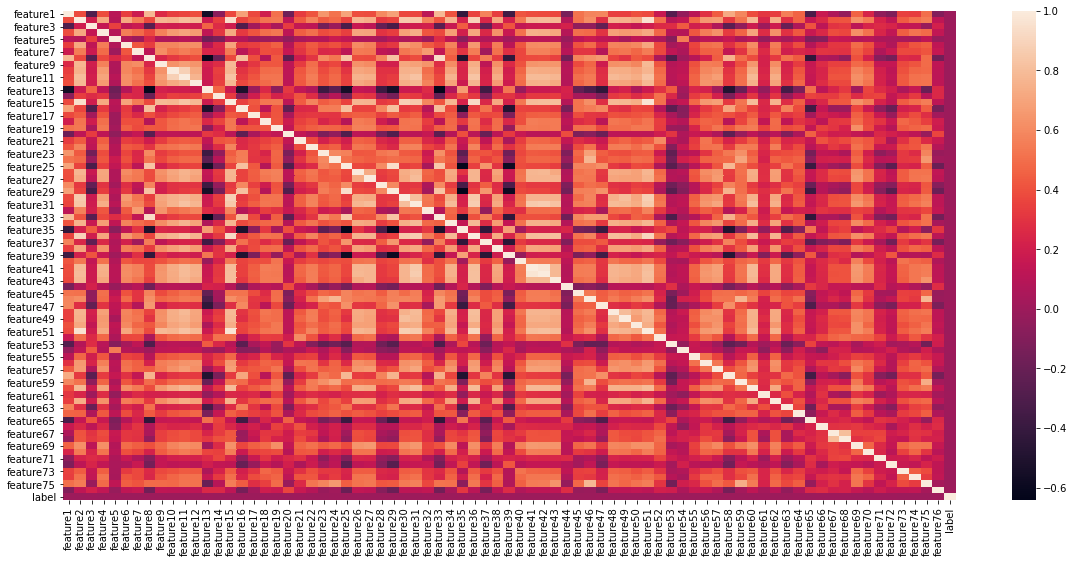

in what range you want of correlation you want your data : 0.7
we can relate with the number of the nan value for the condition . For our condition it should have less Nan values because in correlation matrix  there are less features which have correlatio then out condition.
do you want to visual of the number on nan for checking the how many nan values present the dataset (yes,no) : yes


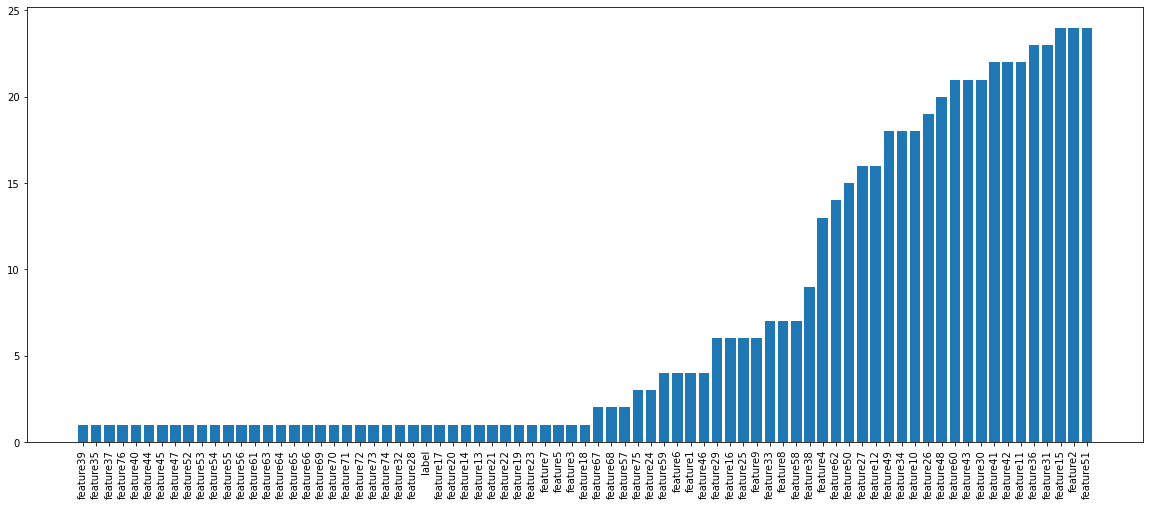

time to reduce the number of features. select the limit upto whhich nan count you want : 21


In [14]:
imp_feature_df,imp_features = visual_and_imp_features(features_labels)

In [15]:
imp_feature_df.head()

,feature39,feature35,feature37,feature76,feature40,feature44,feature45,feature47,feature52,feature53,...,feature4,feature62,feature50,feature27,feature12,feature49,feature34,feature10,feature26,feature48
0,0,0,0,0,1,0,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
1,0,0,1,0,0,0,1,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,1,0,0,0,1,0,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,0,0,0,0,0,1,1,0,0,...,1,1,1,1,1,0,1,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
imp_features.shape,imp_feature_df.shape

((66,), (651441, 66))

are you doing this for first time on the dataset (yes,no) : no
do you want the correlation only for the x dataset (yes,no) : yes
Index(['feature39', 'feature35', 'feature37', 'feature76', 'feature40',
       'feature44', 'feature45', 'feature47', 'feature52', 'feature53',
       'feature54', 'feature55', 'feature56', 'feature61', 'feature63',
       'feature64', 'feature65', 'feature66', 'feature69', 'feature70',
       'feature71', 'feature72', 'feature73', 'feature74', 'feature32',
       'feature28', 'label', 'feature17', 'feature20', 'feature14',
       'feature13', 'feature21', 'feature22', 'feature19', 'feature23',
       'feature7', 'feature5', 'feature3', 'feature18', 'feature67',
       'feature68', 'feature57', 'feature75', 'feature24', 'feature59',
       'feature6', 'feature1', 'feature46', 'feature29', 'feature16',
       'feature25', 'feature9', 'feature33', 'feature8', 'feature58',
       'feature38', 'feature4', 'feature62', 'feature50', 'feature27',
       'feature12',

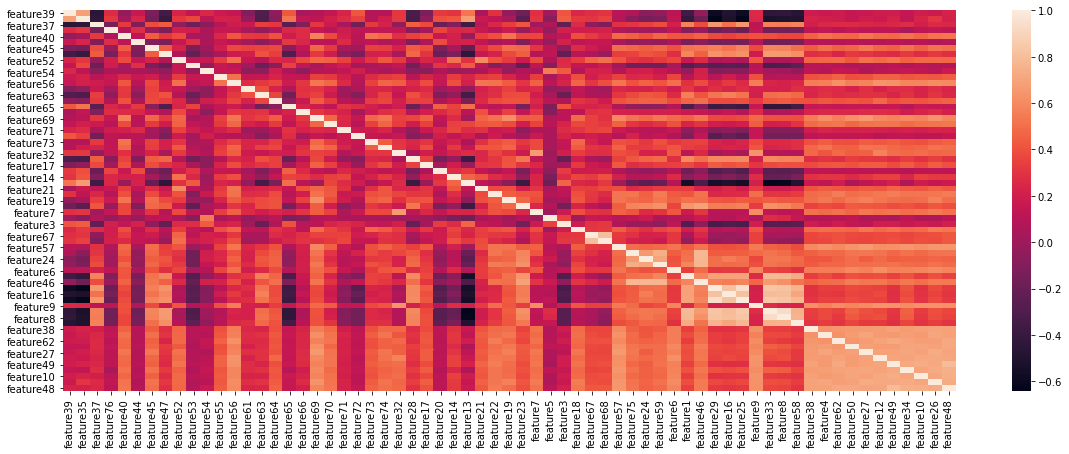

more feature you want to remove (write like a,b,c,etc) : feature38,feature4,feature62,feature50,feature27,feature12,feature49,feature34,feature10,feature26,feature48
Index(['feature39', 'feature35', 'feature37', 'feature76', 'feature40',
       'feature44', 'feature45', 'feature47', 'feature52', 'feature53',
       'feature54', 'feature55', 'feature56', 'feature61', 'feature63',
       'feature64', 'feature65', 'feature66', 'feature69', 'feature70',
       'feature71', 'feature72', 'feature73', 'feature74', 'feature32',
       'feature28', 'feature17', 'feature20', 'feature14', 'feature13',
       'feature21', 'feature22', 'feature19', 'feature23', 'feature7',
       'feature5', 'feature3', 'feature18', 'feature67', 'feature68',
       'feature57', 'feature75', 'feature24', 'feature59', 'feature6',
       'feature1', 'feature46', 'feature29', 'feature16', 'feature25',
       'feature9', 'feature33', 'feature8', 'feature58'],
      dtype='object')


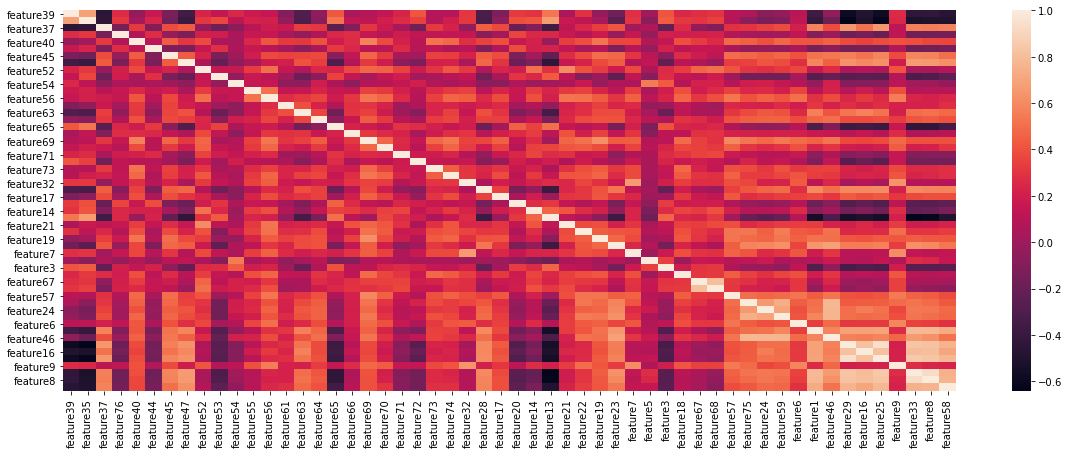

more feature you want to remove (write like a,b,c,etc) : feature8,feature58,feature25,feature46,feature47,feature23
are you satisfied with the features you removed (yes,no) : yes


In [21]:
imp,imp_f = visual_and_imp_features(imp_feature_df)

In [22]:
imp.head()

,feature39,feature35,feature37,feature76,feature40,feature44,feature45,feature47,feature52,feature53,...,feature6,feature1,feature46,feature29,feature16,feature25,feature9,feature33,feature8,feature58
0,0,0,0,0,1,0,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
1,0,0,1,0,0,0,1,0,0,0,...,0,1,1,1,1,1,1,1,1,1
2,1,0,0,0,1,0,1,0,1,1,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,1,1,0,0,...,1,0,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
imp_f

Index(['feature39', 'feature35', 'feature37', 'feature76', 'feature40',
       'feature44', 'feature45', 'feature47', 'feature52', 'feature53',
       'feature54', 'feature55', 'feature56', 'feature61', 'feature63',
       'feature64', 'feature65', 'feature66', 'feature69', 'feature70',
       'feature71', 'feature72', 'feature73', 'feature74', 'feature32',
       'feature28', 'feature17', 'feature20', 'feature14', 'feature13',
       'feature21', 'feature22', 'feature19', 'feature23', 'feature7',
       'feature5', 'feature3', 'feature18', 'feature67', 'feature68',
       'feature57', 'feature75', 'feature24', 'feature59', 'feature6',
       'feature1', 'feature46', 'feature29', 'feature16', 'feature25',
       'feature9', 'feature33', 'feature8', 'feature58'],
      dtype='object')

In [26]:
features_labels.shape,imp_feature_df.shape,imp.shape

((651441, 78), (651441, 66), (651441, 54))

In [27]:
label_0 = features_labels[features_labels['label'] == 0]

In [28]:
label_0.shape

(62219, 78)

In [29]:
print(imp_feature_df.columns[:30])
label_0.columns[:30]

Index(['feature39', 'feature35', 'feature37', 'feature76', 'feature40',
       'feature44', 'feature45', 'feature47', 'feature52', 'feature53',
       'feature54', 'feature55', 'feature56', 'feature61', 'feature63',
       'feature64', 'feature65', 'feature66', 'feature69', 'feature70',
       'feature71', 'feature72', 'feature73', 'feature74', 'feature32',
       'feature28', 'label', 'feature17', 'feature20', 'feature14'],
      dtype='object')


Index(['key', 'feature1', 'feature2', 'feature3', 'feature4', 'feature5',
       'feature6', 'feature7', 'feature8', 'feature9', 'feature10',
       'feature11', 'feature12', 'feature13', 'feature14', 'feature15',
       'feature16', 'feature17', 'feature18', 'feature19', 'feature20',
       'feature21', 'feature22', 'feature23', 'feature24', 'feature25',
       'feature26', 'feature27', 'feature28', 'feature29'],
      dtype='object')

** **
**sampling technique**

In [30]:
# science out dataset is we have to balance and there are two type under and over
# under sampling will remove the data which weight the minority data 
# over sampling will add the extra data to balance the classes 

sampled_data = pd.concat([label_0,features_labels,label_0,label_0,label_0,label_0,label_0,label_0])

In [31]:
print(sampled_data.shape)
sampled_data.head()

(1086974, 78)


,key,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature68,feature69,feature70,feature71,feature72,feature73,feature74,feature75,feature76,label
5,00004d0edbe109811a27af46547d96ea87532ab43ebaa6...,0,1,0,1,0,1,0,1,0,...,1,1,0,0,0,0,0,1,0,0.0
19,0000cfcf58c345dbcb0a73e061385a8aa176e48a8263a9...,0,0,0,1,0,0,1,0,0,...,1,0,0,0,1,1,0,1,0,0.0
28,000122f8308f499c3c5986874191c73146f97d8df5cf1f...,0,1,0,1,0,1,1,0,1,...,0,1,1,0,0,1,1,0,0,0.0
29,0001244c5718b155dbe60da50eacd9e23199a560d51284...,1,1,0,1,0,1,1,1,1,...,1,1,0,1,0,1,1,1,0,0.0
36,00016b2a4ba13424b0ea7a1acaff908f5a33f791397ac5...,1,1,1,1,1,1,1,1,1,...,0,1,1,1,0,1,0,1,0,0.0


In [32]:
sampled_data = sampled_data.sample(frac=1)

In [33]:
sampled_data.label.value_counts()

1.0    589222
0.0    497752
Name: label, dtype: int64

In [34]:
imp_f

Index(['feature39', 'feature35', 'feature37', 'feature76', 'feature40',
       'feature44', 'feature45', 'feature47', 'feature52', 'feature53',
       'feature54', 'feature55', 'feature56', 'feature61', 'feature63',
       'feature64', 'feature65', 'feature66', 'feature69', 'feature70',
       'feature71', 'feature72', 'feature73', 'feature74', 'feature32',
       'feature28', 'feature17', 'feature20', 'feature14', 'feature13',
       'feature21', 'feature22', 'feature19', 'feature23', 'feature7',
       'feature5', 'feature3', 'feature18', 'feature67', 'feature68',
       'feature57', 'feature75', 'feature24', 'feature59', 'feature6',
       'feature1', 'feature46', 'feature29', 'feature16', 'feature25',
       'feature9', 'feature33', 'feature8', 'feature58'],
      dtype='object')

** **
**saving the created data for further use**

throung this we don't have run each step again

**output**
    
    ''dataset saved''

In [35]:
def saving_dataset(cleaned_dataset):
    clean_data = cleaned_dataset
    name = str(input('name for the csv file you want to save and also  at the end put .csv e.g. feature_clean.csv : '))
    return clean_data.to_csv(name,index=False,header=True)

In [36]:
saving_dataset(sampled_data)


name for the csv file you want to save and also  at the end put .csv e.g. feature_clean.csv : feature_labels.csv


In [37]:
sampled_data = pd.read_csv('feature_labels.csv')
sampled_data = sampled_data.sample(frac=1)

In [38]:
sampled_data.columns

Index(['key', 'feature1', 'feature2', 'feature3', 'feature4', 'feature5',
       'feature6', 'feature7', 'feature8', 'feature9', 'feature10',
       'feature11', 'feature12', 'feature13', 'feature14', 'feature15',
       'feature16', 'feature17', 'feature18', 'feature19', 'feature20',
       'feature21', 'feature22', 'feature23', 'feature24', 'feature25',
       'feature26', 'feature27', 'feature28', 'feature29', 'feature30',
       'feature31', 'feature32', 'feature33', 'feature34', 'feature35',
       'feature36', 'feature37', 'feature38', 'feature39', 'feature40',
       'feature41', 'feature42', 'feature43', 'feature44', 'feature45',
       'feature46', 'feature47', 'feature48', 'feature49', 'feature50',
       'feature51', 'feature52', 'feature53', 'feature54', 'feature55',
       'feature56', 'feature57', 'feature58', 'feature59', 'feature60',
       'feature61', 'feature62', 'feature63', 'feature64', 'feature65',
       'feature66', 'feature67', 'feature68', 'feature69', 'featur

In [45]:
x = sampled_data[['feature39', 'feature35', 'feature37', 'feature76', 'feature40',
       'feature44', 'feature45', 'feature47', 'feature52', 'feature53',
       'feature54', 'feature55', 'feature56', 'feature61', 'feature63',
       'feature64', 'feature65', 'feature66', 'feature69', 'feature70',
       'feature71', 'feature72', 'feature73', 'feature74', 'feature32',
       'feature28', 'feature17', 'feature20', 'feature14', 'feature13',
       'feature21', 'feature22', 'feature19', 'feature23', 'feature7',
       'feature5', 'feature3', 'feature18', 'feature67', 'feature68',
       'feature57', 'feature75', 'feature24', 'feature59', 'feature6',
       'feature1', 'feature46', 'feature29', 'feature16', 'feature25',
       'feature9', 'feature33', 'feature8', 'feature58', 'feature12',
       'feature34', 'feature10', 'feature49', 'feature26', 'feature48']]

y = sampled_data['label']

In [46]:
x.shape,y.shape

((1086974, 60), (1086974,))

In [47]:
y.value_counts()

1.0    589222
0.0    497752
Name: label, dtype: int64

In [48]:
X = features_labels[['feature39', 'feature35', 'feature37', 'feature76', 'feature40',
       'feature44', 'feature45', 'feature47', 'feature52', 'feature53',
       'feature54', 'feature55', 'feature56', 'feature61', 'feature63',
       'feature64', 'feature65', 'feature66', 'feature69', 'feature70',
       'feature71', 'feature72', 'feature73', 'feature74', 'feature32',
       'feature28', 'feature17', 'feature20', 'feature14', 'feature13',
       'feature21', 'feature22', 'feature19', 'feature23', 'feature7',
       'feature5', 'feature3', 'feature18', 'feature67', 'feature68',
       'feature57', 'feature75', 'feature24', 'feature59', 'feature6',
       'feature1', 'feature46', 'feature29', 'feature16', 'feature25',
       'feature9', 'feature33', 'feature8', 'feature58', 'feature12',
       'feature34', 'feature10', 'feature49', 'feature26', 'feature48']]

Y = features_labels['label']

In [49]:
X.shape,Y.shape

((651441, 60), (651441,))

In [50]:
Y.value_counts()

1.0    589222
0.0     62219
Name: label, dtype: int64

** **
**train test split**

there is option if you want the some features you forgot before you can remove here
    there is **imp_fea

**output function**

    
    x_train,
    x_test,
    y_train,
    y_test

In [51]:
def modified_train_test_split(x_dataset,y_dataset,imp_feature=None):
    
    any_imp_f = str(input('do you have any important feature (yes,no): '))
    
    if any_imp_f == 'no':
        train_size_ = float(input('training dataset size : '))
        random_state_ = int(input('random state : '))
        x_train, x_test, y_train, y_test = train_test_split(x_dataset,y_dataset,train_size=train_size_,
                                                            random_state=random_state_)
        
    elif any_imp_f == 'yes':
        column = [str(input('the features names :'  'feature1','feature2','...' ' : '))]
        x_dataset = x_dataset[imp_features[columns]]
        y_dataset = y_dataset
            
        train_size_ = float(input('training dataset size : '))
        random_state_ = int(input('random state : '))
            
        x_train, x_test, y_train, y_test = train_test_split(x_dataset,y_dataset,train_size=train_size_,
                                                            random_state=random_state_)
    
    return x_train,x_test,y_train,y_test



In [52]:
x_train,x_test,y_train,y_test = modified_train_test_split(x,y)

do you have any important feature (yes,no): no
training dataset size : 0.8
random state : 1


In [53]:
y_train.value_counts(),y_test.value_counts()

(1.0    471315
 0.0    398264
 Name: label, dtype: int64,
 1.0    117907
 0.0     99488
 Name: label, dtype: int64)

In [54]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((869579, 60), (217395, 60), (869579,), (217395,))

In [55]:
Xta,Xts,Yta,Yts = modified_train_test_split(X,Y)

do you have any important feature (yes,no): no
training dataset size : 0.8
random state : 1


In [56]:
Yta.value_counts(),Yts.value_counts()

(1.0    471378
 0.0     49774
 Name: label, dtype: int64,
 1.0    117844
 0.0     12445
 Name: label, dtype: int64)

In [57]:
Xta.shape,Xts.shape,Yta.shape,Yts.shape

((521152, 60), (130289, 60), (521152,), (130289,))

** **
**loading the model**

In [71]:
lr = LogisticRegression()
rf = RandomForestClassifier()
xgboost = XGBClassifier()

** **
**fucntion for  modeling the dataset**
**output function**

    model
    result (actual, predict, probability)

other - classification report

In [75]:
def model_fir_report_roc_curve(model,x_train_,x_test_,y_train_,y_test_):
    start = time.time()
    
#model training
    model = model.fit(x_train_,y_train_)

# model prediction
    result = {
            'actual' : y_test_,
            'predict' : model.predict(x_test_),
            'probability_predict' : model.predict_proba(x_test_)
        }

#model score for train and test
    want_model_score = str(input('want to check the train and test score (yes,no) : '))
    if want_model_score == 'yes':
        print('score test - ',model.score(x_test_,y_test_),'\nscore train - ',model.score(x_train_,y_train_))

# classification report
    classifi_report = str(input('do you want the classification report (yes,no): '))
    if classifi_report == 'yes':
        print(classification_report(result['actual'],result['predict']))
    else:
        pass
    
# roc curve
    roc_crve_ = str(input('do you want the roc curve (yes,no) : '))
    if roc_crve_ == 'yes':
        
        fpr_lr, tpr_lr, threshold_lr = metrics.roc_curve(result['actual'], result['predict'])
        roc_auc = metrics.auc(fpr_lr, tpr_lr)
        
        skplt.metrics.plot_roc_curve(result['actual'], result['probability_predict'])
        model_name = str(input('which model you are working on (logistic regression, random forest, xg boost) : '))
        plt.title(model_name)
        plt.show()


    end = time.time()
    print('\n\ntime taken by the model - ',end - start)
    
    return model,result

**with balanced data**

want to check the train and test score (yes,no) : yes
score test -  0.5423629798293429 
score train -  0.542003659242001
do you want the classification report (yes,no): yes
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     99488
         1.0       0.54      1.00      0.70    117907

    accuracy                           0.54    217395
   macro avg       0.27      0.50      0.35    217395
weighted avg       0.29      0.54      0.38    217395

do you want the roc curve (yes,no) : yes
which model you are working on (logistic regression, random forest, xg boost) : logistic regression


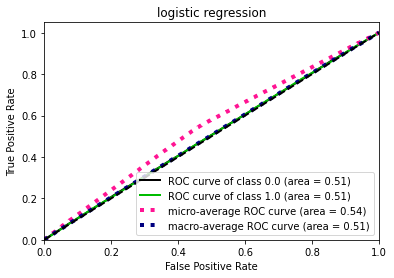



time taken by the model -  46.91066884994507


In [76]:
lr_model,lr_result = model_fir_report_roc_curve(lr,x_train,x_test,y_train,y_test)

want to check the train and test score (yes,no) : yes
score test -  0.767349755054164 
score train -  0.783860925804326
do you want the classification report (yes,no): yes
              precision    recall  f1-score   support

         0.0       0.80      0.66      0.72     99488
         1.0       0.75      0.86      0.80    117907

    accuracy                           0.77    217395
   macro avg       0.77      0.76      0.76    217395
weighted avg       0.77      0.77      0.76    217395

do you want the roc curve (yes,no) : yes
which model you are working on (logistic regression, random forest, xg boost) : random forest


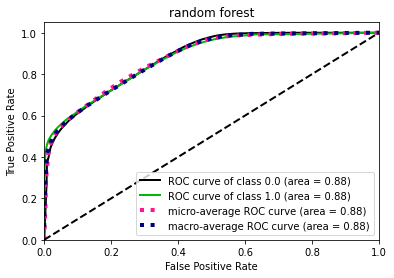



time taken by the model -  744.1983189582825


In [77]:
rf_model,rf_result = model_fir_report_roc_curve(rf,x_train,x_test,y_train,y_test)

[11:19:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
want to check the train and test score (yes,no) : yes
score test -  0.5709882931990156 
score train -  0.582414018737803
do you want the classification report (yes,no): yes
              precision    recall  f1-score   support

         0.0       0.61      0.17      0.26     99488
         1.0       0.56      0.91      0.70    117907

    accuracy                           0.57    217395
   macro avg       0.59      0.54      0.48    217395
weighted avg       0.59      0.57      0.50    217395

do you want the roc curve (yes,no) : yes
which model you are working on (logistic regression, random forest, xg boost) : xgboost


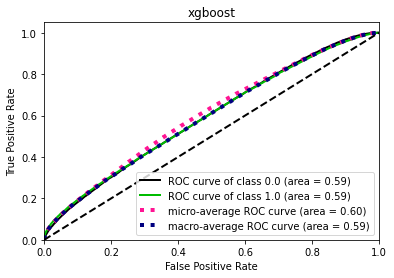



time taken by the model -  218.58928847312927


In [78]:
xg_model,xg_result = model_fir_report_roc_curve(xgboost,x_train,x_test,y_train,y_test)

**without balanced data**

want to check the train and test score (yes,no) : yes
score test -  0.9044815755743002 
score train -  0.9044923553972737
do you want the classification report (yes,no): yes
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     12445
         1.0       0.90      1.00      0.95    117844

    accuracy                           0.90    130289
   macro avg       0.45      0.50      0.47    130289
weighted avg       0.82      0.90      0.86    130289

do you want the roc curve (yes,no) : yes
which model you are working on (logistic regression, random forest, xg boost) : logistic regression


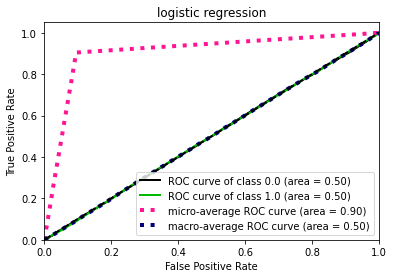



time taken by the model -  29.03692650794983


In [79]:
LR_M,LR_R = model_fir_report_roc_curve(lr,Xta,Xts,Yta,Yts)

want to check the train and test score (yes,no) : yes
score test -  0.8973819739195174 
score train -  0.940583553358713
do you want the classification report (yes,no): yes
              precision    recall  f1-score   support

         0.0       0.10      0.01      0.02     12445
         1.0       0.90      0.99      0.95    117844

    accuracy                           0.90    130289
   macro avg       0.50      0.50      0.48    130289
weighted avg       0.83      0.90      0.86    130289

do you want the roc curve (yes,no) : yes
which model you are working on (logistic regression, random forest, xg boost) : random forest


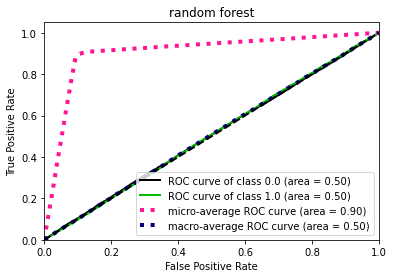



time taken by the model -  356.08456158638


In [80]:
RF_M,RF_R = model_fir_report_roc_curve(rf,Xta,Xts,Yta,Yts)

[11:29:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
want to check the train and test score (yes,no) : yes
score test -  0.9044815755743002 
score train -  0.9045978908264767
do you want the classification report (yes,no): yes
              precision    recall  f1-score   support

         0.0       0.50      0.00      0.00     12445
         1.0       0.90      1.00      0.95    117844

    accuracy                           0.90    130289
   macro avg       0.70      0.50      0.48    130289
weighted avg       0.87      0.90      0.86    130289

do you want the roc curve (yes,no) : yes
which model you are working on (logistic regression, random forest, xg boost) : xgboost


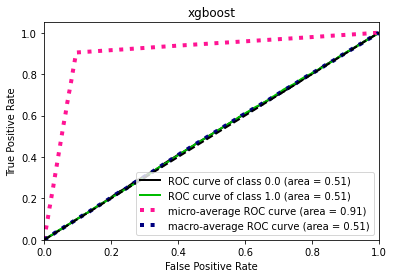



time taken by the model -  143.23493599891663


In [81]:
XG_M,XG_R = model_fir_report_roc_curve(xgboost,Xta,Xts,Yta,Yts)


### never seen data (no labels, just features) and uses models above to generate prediction
** **

In [85]:
def unseen_data_pred(model,x_test,unseen_data):
    cleaned = str(input('have you removed the extra feature or keys : '))
    if cleaned == 'yes':
        return model.predict(unseen_data)
    elif cleaned == 'no':
        print(x_test.columns)
        unseen_data = unseen_data[x_test.columns]
        return model.predict(unseen_data)

In [86]:
lr_unseen_pred = unseen_data_pred(lr_model,x_test,unseen_data)

have you removed the extra feature or keys : no
Index(['feature39', 'feature35', 'feature37', 'feature76', 'feature40',
       'feature44', 'feature45', 'feature47', 'feature52', 'feature53',
       'feature54', 'feature55', 'feature56', 'feature61', 'feature63',
       'feature64', 'feature65', 'feature66', 'feature69', 'feature70',
       'feature71', 'feature72', 'feature73', 'feature74', 'feature32',
       'feature28', 'feature17', 'feature20', 'feature14', 'feature13',
       'feature21', 'feature22', 'feature19', 'feature23', 'feature7',
       'feature5', 'feature3', 'feature18', 'feature67', 'feature68',
       'feature57', 'feature75', 'feature24', 'feature59', 'feature6',
       'feature1', 'feature46', 'feature29', 'feature16', 'feature25',
       'feature9', 'feature33', 'feature8', 'feature58', 'feature12',
       'feature34', 'feature10', 'feature49', 'feature26', 'feature48'],
      dtype='object')


In [87]:
lr_unseen_pred

array([1., 1., 1., ..., 1., 1., 1.])

In [88]:
rf_unseen_pred = unseen_data_pred(rf_model,x_test,unseen_data)

have you removed the extra feature or keys : no
Index(['feature39', 'feature35', 'feature37', 'feature76', 'feature40',
       'feature44', 'feature45', 'feature47', 'feature52', 'feature53',
       'feature54', 'feature55', 'feature56', 'feature61', 'feature63',
       'feature64', 'feature65', 'feature66', 'feature69', 'feature70',
       'feature71', 'feature72', 'feature73', 'feature74', 'feature32',
       'feature28', 'feature17', 'feature20', 'feature14', 'feature13',
       'feature21', 'feature22', 'feature19', 'feature23', 'feature7',
       'feature5', 'feature3', 'feature18', 'feature67', 'feature68',
       'feature57', 'feature75', 'feature24', 'feature59', 'feature6',
       'feature1', 'feature46', 'feature29', 'feature16', 'feature25',
       'feature9', 'feature33', 'feature8', 'feature58', 'feature12',
       'feature34', 'feature10', 'feature49', 'feature26', 'feature48'],
      dtype='object')


In [89]:
rf_unseen_pred

array([1., 1., 1., ..., 1., 1., 1.])

In [90]:
xg_unseen_pred = unseen_data_pred(xg_model,x_test,unseen_data)

have you removed the extra feature or keys : no
Index(['feature39', 'feature35', 'feature37', 'feature76', 'feature40',
       'feature44', 'feature45', 'feature47', 'feature52', 'feature53',
       'feature54', 'feature55', 'feature56', 'feature61', 'feature63',
       'feature64', 'feature65', 'feature66', 'feature69', 'feature70',
       'feature71', 'feature72', 'feature73', 'feature74', 'feature32',
       'feature28', 'feature17', 'feature20', 'feature14', 'feature13',
       'feature21', 'feature22', 'feature19', 'feature23', 'feature7',
       'feature5', 'feature3', 'feature18', 'feature67', 'feature68',
       'feature57', 'feature75', 'feature24', 'feature59', 'feature6',
       'feature1', 'feature46', 'feature29', 'feature16', 'feature25',
       'feature9', 'feature33', 'feature8', 'feature58', 'feature12',
       'feature34', 'feature10', 'feature49', 'feature26', 'feature48'],
      dtype='object')
